In [4]:
import time
import itertools
import numpy as np

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator

from qiskit.opflow import CircuitSampler

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap("plasma") #'viridis'

from modules.utils import *

from qae import *

import datetime

In [5]:
import tenpy
from tenpy.networks.mps import MPS
from tenpy.models.hubbard import BoseHubbardChain
from tenpy.algorithms import dmrg
from tenpy.linalg import np_conserved

def DMRG_EBH(L, V, t_list, chi_max=30, bc_MPS='infinite'):

    model_params = dict(n_max=1, filling=0.5, bc_MPS=bc_MPS, t=t_list,
                        L=L, V=V, mu=0, conserve='N')
    M = BoseHubbardChain(model_params)
        
    vector=[]
    for i in range(M.lat.N_sites):
        if i%2:
            vector.append(1)
        else:
            vector.append(0)

    psi = MPS.from_product_state(M.lat.mps_sites(), vector, bc=M.lat.bc_MPS)    
        
    dmrg_params = {                                                                                             
        'mixer': True,                                                                                          
        'trunc_params': {                                                                                       
        'chi_max': chi_max,                                                                                                                                                                    
        },                                                                                                      
        'max_E_err': 1.e-16,                                                                                    
        #'verbose': 0
    }
    
    info = dmrg.run(psi, M, dmrg_params)
    
    return info['E'], psi

In [6]:
print(qiskit.__version__, np.__version__, tenpy.__version__)

0.17.4 1.20.1 0.8.4


In [7]:
#IBMQ.load_account() # this then automatically loads your saved account
#provider = IBMQ.get_provider(hub='ibm-q-research')

In [8]:
#device = provider.backend.ibmq_rome # 6 bogota ; 4 rome

In [135]:
### Real device execution:
#backend = device 

### Simulation with noise profile from real device
#backend = qiskit.providers.aer.AerSimulator.from_backend(device)

### Simulation without noise
qiskit_chi = 100

backend = qiskit.providers.aer.AerSimulator(method="matrix_product_state",
                                            precision="single",
                                            matrix_product_state_max_bond_dimension = qiskit_chi,
                                            matrix_product_state_truncation_threshold = 1e-10,
                                            #mps_sample_measure_algorithm = "mps_apply_measure", #alt: "mps_probabilities" 
                                           )

#backend = qiskit.providers.aer.QasmSimulator(method="matrix_product_state",
#                                            precision="single",
#                                            matrix_product_state_max_bond_dimension = qiskit_chi,
#                                            matrix_product_state_truncation_threshold = 1e-10,
#                                            #mps_sample_measure_algorithm = "mps_apply_measure", #alt: "mps_probabilities" 
#                                           )
#backend = StatevectorSimulator()

In [134]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

In [97]:
### Preliminaries
L = 8
num_trash = int(np.log(L)/np.log(2))
anti = 1 # 1 for ferromagnetic Ising model, -1 for antiferromagnet

filename = "data/QAEAnsatz_scaling_MPS"

In [99]:
V = 1
deltat=1
chi = 100
print("bond dimension : ", chi)

bond dimension :  100


In [100]:
t_list = np.ones(L-1)
for i in range(len(t_list)):
    t_list[i] -= deltat*(-1)**i
E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')

/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


In [101]:
def qiskit_state(psi0):
    # G is only the local tensor (not multiplied by any singular values) - see https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mps.html
    A_list = [psi0.get_B(i, form="G").to_ndarray().transpose([1,0,2]) for i in range(L)]
    for i,A in enumerate(A_list):
        A_list[i] = (A[0], A[1])
    S_list = [psi0.get_SR(i) for i in range(L-1)] # skip trivial last bond; hast to be of size L-1
    return (A_list, S_list)

Test state preparation

In [69]:
initcirc = QuantumCircuit(QuantumRegister(L,"q")) #,ClassicalRegister(num_trash, 'c'))
initcirc.set_matrix_product_state(qiskit_state(psi0))

qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                                  shots = 1000)

In [70]:
QZ = np.zeros(L)

In [71]:
for i in range(L):
    meas_outcome = ~StateFn(QNKron(L,Z,I,i)) @ StateFn(initcirc)
    QZ[i] = CircuitSampler(qi).convert(meas_outcome).eval()

<ipython-input-71-50c7739f7155>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  QZ[i] = CircuitSampler(qi).convert(meas_outcome).eval()


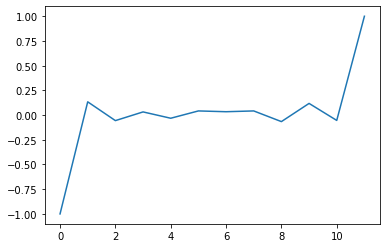

In [72]:
plt.plot(QZ)

should display the edge states for $V=1$ and $\delta t=1$

In [102]:
def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True,vqe=False):
    # QAE ansatz
    QAE_circ = QAEAnsatz(num_qubits = L, num_trash_qubits= num_trash, trash_qubits_idxs = list(range(num_trash)), measure_trash=measurement).assign_parameters(thetas)
    # initialize state vector
    initcirc = QuantumCircuit(QuantumRegister(L,"q"),ClassicalRegister(num_trash, 'c'))
    initcirc.set_matrix_product_state(qiskit_state(init_state))
    # compose circuits
    fullcirc = initcirc.compose(QAE_circ)
    return fullcirc

In [103]:
circ = prepare_circuit(thetas = np.random.rand(2*L+2), L = L, init_state = psi0)
#circ.draw("mpl")

In [104]:
### Execute circuit
count = 0
def run_circuit(thetas, L, num_trash, init_state, vqe=False, shots=100, meas_fitter = None):
    #global count
    #count += 1
    #print(count, "thetas: ", thetas)
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    tcirc = qiskit.transpile(circ, backend)
    # Execute the circuit 
    job_sim = backend.run(tcirc, shots=shots) # , seed_simulator=123, seed_transpiler=234 fix seed to make it reproducible
    result = job_sim.result()
    # Results without mitigation
    counts = result.get_counts()
    if meas_fitter != None:
        # Get the filter object
        meas_filter = meas_fitter.filter

        # Results with mitigation
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)
    return counts

In [105]:
t0 = time.time()
res = run_circuit(thetas = np.random.rand(num_trash*L+num_trash), L = L, num_trash = num_trash, init_state = psi0, shots=1000)
print("execution time: ", time.time()-t0)

execution time:  0.03638792037963867


In [106]:
res

{'101': 49,
 '111': 59,
 '011': 62,
 '000': 134,
 '100': 246,
 '110': 164,
 '010': 222,
 '001': 64}

In [107]:
def count_ones(string):
    return np.sum([int(_) for _ in string])

In [108]:
count_ones("01010111")

5

In [109]:
[_ for _ in res]

['101', '111', '011', '000', '100', '110', '010', '001']

In [110]:
[_ for _ in res if _ != "0" * num_trash]

['101', '111', '011', '100', '110', '010', '001']

In [111]:
np.sum([res[_]*count_ones(_) for _ in res if _ != "0" * num_trash]) # all measurement results except "000"

1259

In [112]:
### Optimize circuit
def cost_function_single(thetas, L, num_trash, init_state, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots, meas_fitter=meas_fitter)
    cost = np.sum([out[_]*count_ones(_) for _ in out if _ != "0" * num_trash]) # all measurement results except "000"
    return cost/shots

def cost_function(thetas, L, num_trash, init_states, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    cost = 0.
    for init_state in init_states:
        cost += cost_function_single(thetas, L, num_trash, init_state, shots, vqe, param_encoding, meas_fitter=meas_fitter)
    return cost/len(init_states)

def optimize(init_states, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None,
            meas_fitter=None):
    if thetas is None:
        n_params = (num_trash*L+num_trasg)*2 if param_encoding else (num_trash*L+num_trash)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    #print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=0.3,
                         #perturbation=0.1
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance
    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x, meas_fitter=meas_fitter)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [113]:
thetas_opt_mitigated, losses, accepted = optimize([psi0], max_iter=120, L=L, meas_fitter=None) #, pick_optimizer="adam")

Time: 10.74302 sec
(array([ 3.07632914,  2.30718613,  0.87170037,  3.69723067, -2.6571439 ,
       10.28759224,  1.75217589,  6.15061212,  6.32569571,  3.40554364,
        4.66978687,  5.28880287,  1.09823067,  2.83735368,  5.79602388,
        3.54326178,  3.17749819,  4.46821927]), 0.035, 360)


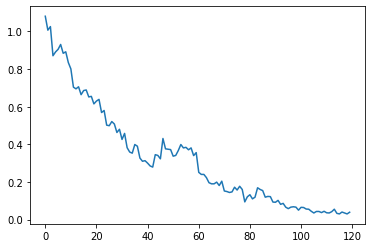

In [114]:
plt.plot(losses)

# Scaling

In [138]:
Ls = [3,4,12,16,32]
max_iter = [200,200,200,300,300]
num_trashs = np.log(Ls)/np.log(2)
num_trashs = np.array(num_trashs, dtype="int")

In [139]:
num_trashs

array([1, 2, 3, 4, 5])

In [117]:
losses = [None] * len(Ls); accepted = [None] * len(Ls); thetas_opt= [None] * len(Ls)

3 1


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Time: 8.27206 sec
(array([6.28651645, 3.00643019, 2.27897375, 6.28533248]), 0.0, 600)


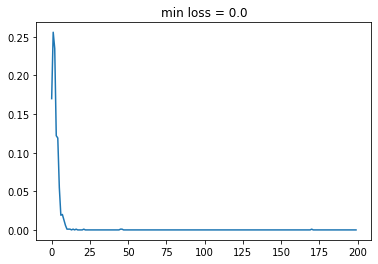

In [121]:
j=0
L, num_trash = Ls[j], num_trashs[j]
print(L,num_trash)
t_list = np.ones(L-1)
for i in range(len(t_list)):
    t_list[i] -= deltat*(-1)**i
E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')
thetas_opt[j], losses[j], accepted[j] = optimize([psi0], max_iter=max_iter[j], L=L, num_trash=num_trash, meas_fitter=None) #, pick_optimizer="adam")
plt.plot(losses[j])
plt.title(f"min loss = {np.min(losses[j])}")
plt.show()

4 2


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Time: 12.39246 sec
(array([ 0.78015555,  4.95464755,  4.46083066,  3.05600151,  5.51438032,
        5.004491  ,  5.98475244,  3.70687481, -0.13860963,  1.43963763]), 0.002, 600)


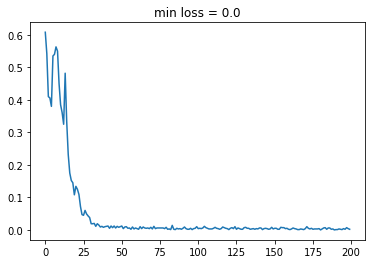

In [122]:
j=1
L, num_trash = Ls[j], num_trashs[j]
print(L,num_trash)
t_list = np.ones(L-1)
for i in range(len(t_list)):
    t_list[i] -= deltat*(-1)**i
E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')
thetas_opt[j], losses[j], accepted[j] = optimize([psi0], max_iter=max_iter[j], L=L, num_trash=num_trash, meas_fitter=None) #, pick_optimizer="adam")
plt.plot(losses[j])
plt.title(f"min loss = {np.min(losses[j])}")
plt.show()

In [140]:
j=2
L, num_trash = Ls[j], num_trashs[j]
print(L,num_trash)
t_list = np.ones(L-1)
for i in range(len(t_list)):
    t_list[i] -= deltat*(-1)**i
E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')

12 3


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."
/home/kkottmann/TeNPy/tenpy/tools/params.py:223: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Time: 157.11983 sec
(array([ 3.19499203, -2.28571305,  6.99286236,  5.10148785,  0.18020187,
        7.64728968,  4.96477003,  1.1226144 ,  6.67314408,  4.52950715,
        3.03768063,  4.82817083,  3.22015824,  6.30817567,  3.08601871,
        5.2972768 ,  3.75987471,  3.34705618,  6.12894939,  1.82421347,
        0.66710274,  4.38344646,  2.39623431, -3.84000158,  3.20282187,
        0.07649583,  3.27101394,  5.25789388,  0.43937262,  2.87406566,
        0.75791495,  3.53690728,  4.04650364,  4.42538092,  1.93401827,
        5.44067072,  3.06872342,  1.43111399,  0.46975912]), 0.487, 600)


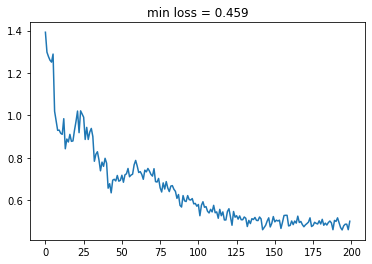

In [141]:
thetas_opt[j], losses[j], accepted[j] = optimize([psi0], max_iter=max_iter[j], L=L, num_trash=num_trash, meas_fitter=None) #, pick_optimizer="adam")
plt.plot(losses[j])
plt.title(f"min loss = {np.min(losses[j])}")
plt.show()

In [ ]:
j=3
L, num_trash = Ls[j], num_trashs[j]
print(L,num_trash)
t_list = np.ones(L-1)
for i in range(len(t_list)):
    t_list[i] -= deltat*(-1)**i
E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')
thetas_opt[j], losses[j], accepted[j] = optimize([psi0], max_iter=max_iter[j], L=L, num_trash=num_trash, meas_fitter=None) #, pick_optimizer="adam")
plt.plot(losses[j])
plt.title(f"min loss = {np.min(losses[j])}")
plt.show()

3 1


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Time: 7.31577 sec
(array([1.35451217, 2.06295882, 4.22419098, 1.35475741]), 0.0, 600)


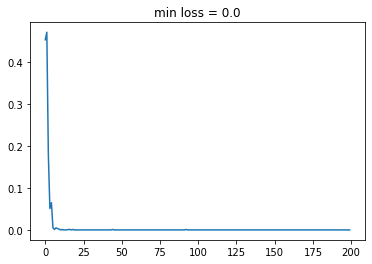

4 2


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Time: 10.87325 sec
(array([ 3.14030410e+00,  3.95846365e+00,  4.02076389e+00,  3.13065946e+00,
        3.13715661e+00,  3.79653409e+00,  5.76164365e+00,  4.56784018e+00,
       -8.39293525e-04,  1.79976826e+00]), 0.0, 600)


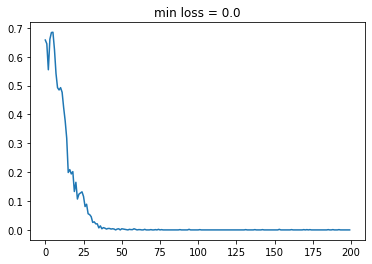

8 3


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Time: 33.10143 sec
(array([ 3.13095373,  8.71683255,  2.50542712,  3.35162993,  2.26179756,
        6.33730274, -0.38019221, -0.07373724, -0.01909336,  6.17101323,
        4.8327714 ,  2.42943577,  4.78822677,  5.25884107,  5.97352589,
        4.60323196,  3.07677885,  4.82030213,  3.12958861,  1.90749458,
        9.16015035,  3.68716278,  3.06791303,  1.13986599, -0.11031543,
       -0.02285825,  0.5478112 ]), 0.459, 900)


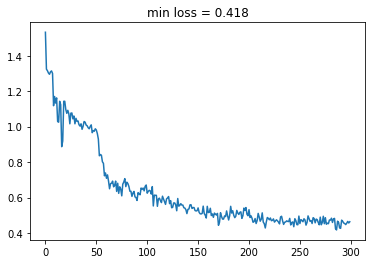

16 4


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."
/home/kkottmann/TeNPy/tenpy/tools/params.py:223: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


KeyboardInterrupt: 

In [118]:
for j,(L,num_trash) in enumerate(zip(Ls,num_trashs)):
    print(L,num_trash)
    t_list = np.ones(L-1)
    for i in range(len(t_list)):
        t_list[i] -= deltat*(-1)**i
    E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')
    thetas_opt[j], losses[j], accepted[j] = optimize([psi0], max_iter=max_iter[j], L=L, num_trash=num_trash, meas_fitter=None) #, pick_optimizer="adam")
    plt.plot(losses[j])
    plt.title(f"min loss = {np.min(losses[j])}")
    plt.show()

In [ ]:
np.savez(filename + "_losses", losses=losses, thetas_opt = thetas_opt, Ls=Ls, max_iter=max_iter, num_trashs=num_trashs)

In [ ]:
temp = np.load(filename + "_losses.npz", allow_pickle=True)
losses0 = temp["losses"]

In [ ]:
min_losses = [np.min(l) for l in losses0]

In [ ]:
min_losses

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(Ls, min_losses,"x--")
#ax.set_yscale("log")
#ax.set_xscale("log")